In [9]:
import torch
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from torch import nn,autograd


## Pre-Processing

In [10]:
def load_image(name):
    img = image.load_img(name,target_size=(128,128,3))
    img = image.img_to_array(img)
#     img = img/255
    
    #plt.imshow(img)
#     img = np.reshape(img,(224*224*3))
    return img.T

In [11]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    padding=pad_sequences(x,padding='post',maxlen=length)
    return padding

In [12]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(x)
    t=tokenizer.texts_to_sequences(x)
    # TODO: Implement
    return t, tokenizer

In [13]:
def preprocess(sentences):
    text_tokenized, text_tokenizer = tokenize(sentences)
    text_pad = pad(text_tokenized)
    return text_pad, text_tokenizer

In [14]:
metadata = pd.read_csv('../input/flickr-image-dataset/flickr30k_images/results.csv',delimiter='|',engine='python')
metadata = metadata.dropna()
is_NaN = metadata.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = metadata[row_has_NaN]
print(rows_with_NaN)
metadata.head()

Empty DataFrame
Columns: [image_name,  comment_number,  comment]
Index: []


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [15]:
dict_ = {}
for index,row in metadata.iterrows():
    if row['image_name'] in dict_:
        dict_[row['image_name']].append('<SOS>'+row[' comment']+'<EOS>')
    else:
        dict_[row['image_name']]=['<SOS>'+row[' comment']+'<EOS>']
print(len(dict_))

31783


In [16]:
from tensorflow.keras.preprocessing import image
loc = '../input/flickr-image-dataset/flickr30k_images/flickr30k_images/'
image_arr = []
sentence_arr = []
for ind in range(20000):
    if ind % 2 != 0:
        continue
    image_location = (metadata.iloc[ind,:]['image_name'])
    sentence = dict_[image_location]
    
    
    image_arr.append(load_image(loc+str(image_location)) )
    sentence_arr.extend(sentence) #append all 5 captions for that image
    
        


In [17]:
Images =  np.array(image_arr)
Sentence , token_Sentence = preprocess(sentence_arr)
vocab_size=len(token_Sentence.word_index)+1
embedding_size = 512
batch_size=1
max_len_t = len(Sentence[0])
patch_size=16
img_size=128
num_patches = (img_size * img_size) // patch_size**2 

## Loading the saved model 

cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')
c_device = next(c.parameters()).device

In [18]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 512.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=512):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
#         self.flatten = nn.Flatten()
        
        self.flatten = nn.Flatten(start_dim=2,end_dim=3)# only flatten the feature map dimensions into a single vector

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass 
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
#         print(x_flattened.shape)
#         print(x_flattened.permute(2,0,1).shape)
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(2,0,1) #.permute(0,2,1)


In [19]:
class encoder(nn.Module):
    def __init__(self, img_size=img_size,embedding_dim=512,patch_size=16,num_channels=3):
        super().__init__()
        self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim).to(cuda0)

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model=512,
                                                     nhead=4,
                                                     dim_feedforward=2048,
                                                     activation="gelu",
#                                                      batch_first=True,
#                                                      norm_first=True,
                                                     device=cuda0), # Create a single Transformer Encoder Layer
                                                     num_layers=2).to(cuda0)
        #creating positional embedding

        num_patches = (img_size * img_size) // patch_size**2 
        self.positional_embedding = nn.Parameter(torch.randn(num_patches,batch_size,embedding_dim)).to(cuda0)
        
        self.embedding_dropout = nn.Dropout(p=0.1).to(cuda0)
    def forward(self,images):
        
        batches = images.shape[0]
        x = self.patch_embedding(images)
#         print('patch embed',x.shape)
#         x = x[np.newaxis,0:].T
#         print('position embed',self.positional_embedding.shape)
        x = self.positional_embedding + x
        x.requires_grad_()
        trans_encoder = self.transformer_encoder(x)
        return trans_encoder#(1,0,2) 2 is the last index , 0 is the batchsize

In [20]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = encoder()
        self.trg_word_embedding = nn.Embedding(vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len_t, embedding_size)
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(d_model=embedding_size,
                                                     nhead=4,
#                                                      batch_first=True,
                                                     activation='gelu',
#                                                      norm_first=True,
                                                     device=cuda0), 
                                                     num_layers=2).to(cuda0)
        self.out = nn.Linear(embedding_size, vocab_size)
        self.dropout = nn.Dropout(0.2).to(cuda0)
    
    def mask(self,sz):
        
        mask = (torch.triu(torch.ones(sz[0], sz[0])) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')). \
        masked_fill(mask == 1, float(0.0))
        return mask
  
        
    def forward(self,img,trg):
#         print(trg.shape)
#         print(type(trg))
#         print(self.trg_word_embedding)
        trg=trg.type(torch.int64)
        trg_seq_length,N = trg.shape
#         print('in gene',trg_seq_length)
        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length,N)
            
        ).to(cuda0)
#         print(trg_positions)

        embed_trg = self.dropout(
                self.trg_word_embedding(trg) +
                 self.trg_position_embedding(trg_positions)
            )
        in_features = self.encoder(img)
#         print('the shape of mat from encoder is ',in_features.shape,
#               '\n embeded trg',embed_trg.shape)
        in_features.requires_grad_()
        trg_mask = self.mask(trg.shape).to(cuda0)
        logits = self.transformer_decoder(embed_trg,in_features,tgt_mask=trg_mask) #in_features is from the encoder
        
        logits = self.out(logits)
#         print(logits.shape)
        return logits

In [21]:
c = torch.load('/kaggle/input/model-from-train/c.h5').to('cuda:0')

In [22]:
c

generator(
  (encoder): encoder(
    (patch_embedding): PatchEmbedding(
      (patcher): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
      (flatten): Flatten(start_dim=2, end_dim=3)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadA

In [23]:
Sentence.shape

(49998, 80)

## Evaluate the results

In [24]:
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')
c_device = next(c.parameters()).device

In [25]:
def create_batch(src, tar , batchsize , i):
    src=  src[(i-1)*batchsize : (i-1)*batchsize + batchsize]
    tar =tar[(1-1)*batchsize : (1-1)*batchsize + batchsize]
    return torch.tensor(src).float(),torch.tensor(tar).T.long()

In [26]:
import matplotlib.pyplot as plt

In [27]:
def display_image(name):
    img = image.load_img(name,target_size=(512,512,3))
    img = image.img_to_array(img)
    img = img/255
    plt.imshow(img)

In [28]:
def evaluate(index):
    ref = ' '.join(metadata[' comment'][index].split())
    
    image_location, sent = metadata.iloc[index,0],metadata.iloc[index,2]
    other = dict_[image_location]
    image_arr = []
    img = load_image(loc+str(image_location))
    image_arr.append(img)
    img_arr = np.array(image_arr)
    sentence = []
    sentence.append(sent)
    sentence[0] = '<SOS> '+sentence[0]+'<EOS>'
    sentence = pad(token_Sentence.texts_to_sequences(sentence) , length = max_len_t)
    src , tar = create_batch(img_arr,sentence, 1,1)
    src = src.to(c_device)
    tar = tar.to(c_device)
    c.eval()
    output =  c(src,tar)
    src.detach()
    tar.detach()
#     loss = criterion(output.view(-1, output.shape[2]), tar.reshape(-1))
    sentence_formed = ''
    val, ind = torch.max(output.view(-1, output.shape[2]), 1)
    for word in ind:
        #print('--->'+sentence_formed+'    '+str(word.item()))
        if word.item() == 3: # EOS
                break
        for key, value in token_Sentence.word_index.items():
            #print(value == word.item()) 
            if value == word.item() and value != 2: # sos
                sentence_formed = sentence_formed + key +' '
                break
    display_image('../input/flickr-image-dataset/flickr30k_images/flickr30k_images/'+str(image_location))
#     print('loss = ',loss)
#     print(output)
    
    print('Individual 1-gram: %f' % sentence_bleu(ref.split(), sentence_formed.split(), weights=(1, 0, 0, 0)))
    print('Individual 2-gram: %f' % sentence_bleu(ref.split(), sentence_formed.split(), weights=(0, 1, 0, 0)))
    print('Individual 3-gram: %f' % sentence_bleu(ref.split(), sentence_formed.split(), weights=(0, 0, 1, 0)))
    print('Individual 4-gram: %f' % sentence_bleu(ref.split(), sentence_formed.split(), weights=(0, 0, 0, 1)))
    score = sentence_bleu(ref.split(), sentence_formed.split(),weights=(0.25, 0.5, 0.15, 0.10))
    print('Orginal ->',ref)
    print('Bleu Score is {}'.format(score))
    for s,i in zip(other,range(5)):
        print(i,s[5:-5])
    print('Sentence Formed ->', sentence_formed)
    return

Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Orginal -> Two young , White males are outside near many bushes .
Bleu Score is 0
0  Two young guys with shaggy hair look at their hands while hanging out in the yard .
1  Two young , White males are outside near many bushes .
2  Two men in green shirts are standing in a yard .
3  A man in a blue shirt standing in a garden .
4  Two friends enjoy time spent together .
Sentence Formed -> two young white males are outside near many bushes 


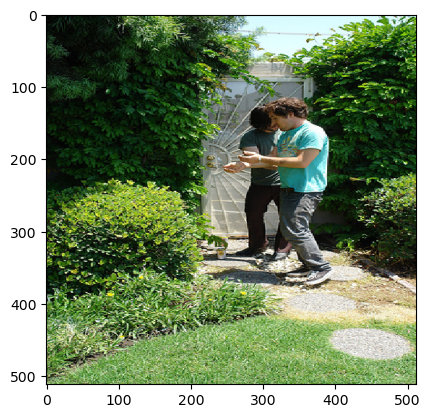

In [29]:
evaluate(1)

Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Orginal -> Two guy cooking and joking around with the camera .
Bleu Score is 0
0  Two men , one in a gray shirt , one in a black shirt , standing near a stove .
1  Two guy cooking and joking around with the camera .
2  Two men in a kitchen cooking food on a stove .
3  Two men are at the stove preparing food .
4  Two men are cooking a meal .
Sentence Formed -> two guy cooking and past around with the camera 


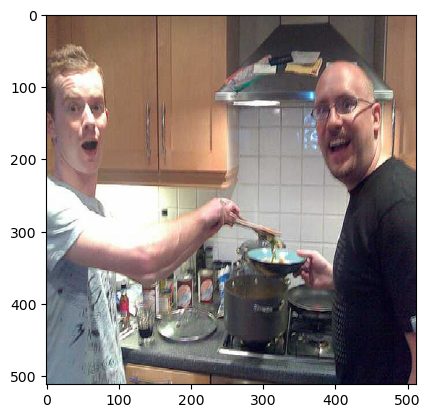

In [30]:
evaluate(21)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Individual 1-gram: 0.071429
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
Orginal -> One man stops to give a sweet kiss to a cow near a train on an overpass .
Bleu Score is 0.5169731539571706
0  A man and a cow re shown in the foreground while a long train is in the back .
1  One man stops to give a sweet kiss to a cow near a train on an overpass .
2  A man makes a kissing face to a cow in front of a train .
3  There is a man getting ready to kiss a cow .
4  A man leans beside a cow in a grassy field .
Sentence Formed -> a man makes a kissing face to a cow in front of a train 


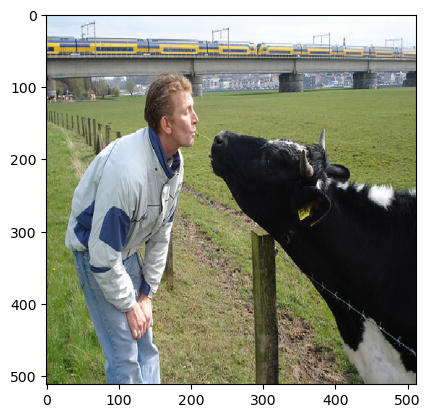

In [31]:
evaluate(28001)

Individual 1-gram: 0.100000
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
Orginal -> two golden dogs are chewing a white cushion on a wooden patio .
Bleu Score is 0.5623413251903491
0  Two medium sized light brown dogs are playing tug-of-war with a dish cloth .
1  two golden dogs are chewing a white cushion on a wooden patio .
2  Two dogs fight over a bag on a wooden deck .
3  Two dogs are fighting over a plastic bag .
4  Two brown dogs fight over some cloth .
Sentence Formed -> two dogs fight over a bag on a wooden deck 


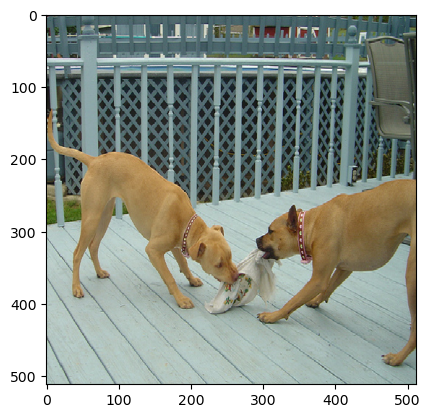

In [32]:
evaluate(30006)

Individual 1-gram: 0.066667
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
Orginal -> An old man with a white shirt and black pants sits on a chair in the opening of a stone tunnel .
Bleu Score is 0.5081327481546147
0  An old man with a white shirt and black pants sits on a chair in the opening of a stone tunnel .
1  A man in a white shirt and dress pants sits just underneath a stone archway .
2  a man wearing a white shirt and black pants sitting on a staircase
3  An old man sits in an ancient brick archway .
4  Elderly man sitting in a doorway .
Sentence Formed -> a man in a white shirt and dress pants sits just underneath a stone tunnel 


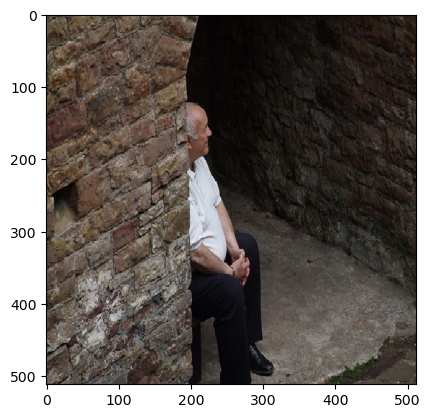

In [33]:
evaluate(31000)

Individual 1-gram: 0.111111
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
Orginal -> A man pointing at food in a casserole dish .
Bleu Score is 0.5773502691896257
0  Two men prepare dinner next to a bottle of beer .
1  A man pointing at food in a casserole dish .
2  A man is checking on crabs in a glass dish .
3  Preparing a fish dinner for the family .
4  A man wearing glasses is cooking .
Sentence Formed -> a man pointing at food in a crosswalk dish 


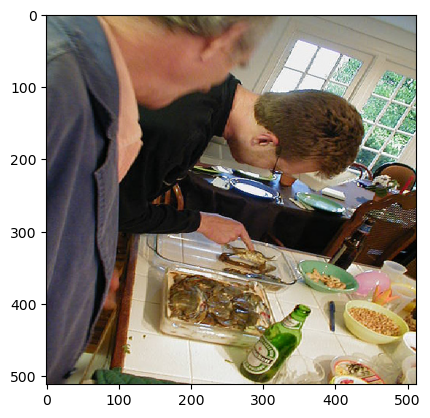

In [34]:
evaluate(15006)

## Meteor

In [35]:
 !pip install -U nltk
from nltk.translate import meteor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


ImportError: cannot import name 'meteor' from 'nltk.translate' (/opt/conda/lib/python3.7/site-packages/nltk/translate/__init__.py)

In [ ]:
meteor = evaluate.load('meteor')
predictions = ["It is a guide to action which ensures that the military always obeys the commands of the party"]
references = ["It is a guide to action that ensures that the military will forever heed Party commands"]
results = meteor.compute(predictions=predictions, references=references)